<a href="https://colab.research.google.com/github/ykitaguchi77/AdvancedPytorch_Colab/blob/master/Pytorch_ukiyoe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#浮世絵予測のPytorchを用いた実装
#https://prob.space/competitions/ukiyoe-author/discussions/takedarts-Post852f7083860909eb1acb



# **セットアップ**
学習データとテストデータをGoogle Driveから読み込みます。 このコードを実行する前に、これらのデータファイルをGoogle Driveの ProbSpace/ukiyoe/ 以下に保存しておいてください。

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


画像の重複を確認するために imagehash をインストールします。画像の重複確認を行わないなら以下のインストールは不要です。

In [0]:
!pip install imagehash

     |████████████████████████████████| 296kB 6.7MB/s 


In [0]:
import google.colab

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch.cuda
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.utils.data as dataset
import torchvision.models as models

import albumentations
import imagehash
import argparse
import os
import tqdm
import random
import csv

DATA_DIR = 'drive/My Drive/ProbSpace/ukiyoe'
RANDOM_SEED = 2019

random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True

#データの読み込み
それぞれのデータをndarrayとして読み込みます。画像のデータ形式は (width, height, channel) となっているようです。

In [0]:
train_labels = np.load(os.path.join(DATA_DIR, 'ukiyoe-train-labels.npz'))['arr_0']
train_images = np.load(os.path.join(DATA_DIR, 'ukiyoe-train-imgs.npz'))['arr_0']
test_images = np.load(os.path.join(DATA_DIR, 'ukiyoe-test-imgs.npz'))['arr_0']

print('train-labels: shape={}, dtype={}'.format(train_labels.shape, train_labels.dtype))
print('train-images: shape={}, dtype={}'.format(train_images.shape, train_images.dtype))
print('test-images: shape={}, dtype={}'.format(test_images.shape, test_images.dtype))

train-labels: shape=(3158,), dtype=int64
train-images: shape=(3158, 224, 224, 3), dtype=uint8
test-images: shape=(397, 224, 224, 3), dtype=uint8


#データの確認
学習データに含まれる各ラベルのデータ数を確認。0, 1, 4, 6は多いですが、5, 7, 8, 9は少なめです。

train-labels: min=0, max=9


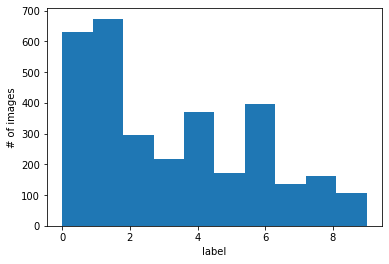

In [0]:
print('train-labels: min={}, max={}'.format(np.min(train_labels), np.max(train_labels)))
axis = plt.figure().add_subplot(1, 1, 1)
axis.set_xlabel('label')
axis.set_ylabel('# of images')
axis.hist(train_labels)
plt.show()

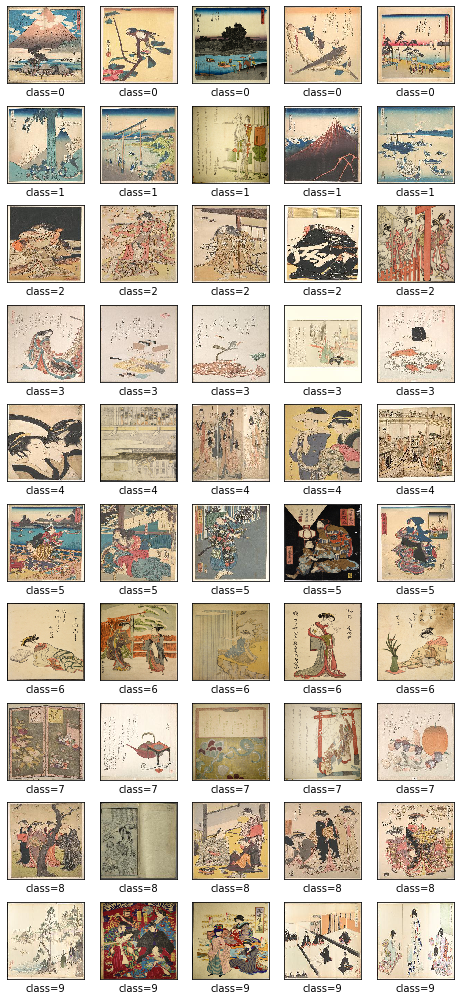

In [0]:
images = [[] for _ in range(10)]

for image, label in zip(train_images, train_labels):
  images[label].append(image)

figure = plt.figure(figsize=(8, 18))

for i in range(10):
  for j, img in enumerate(images[i][:5]):
    axis = figure.add_subplot(10, 5, i * 5 + j + 1)

    axis.imshow(img)
    axis.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    axis.set_xlabel(f'class={i}')

plt.show()

#重複画像の確認
非常に似ている画像が存在していますが、模様の位置やコントラストが異なります（出典元が違うかも）。テストデータの中にも重複していると思われる画像を確認できます。

In [0]:
data = [[f'train_{t}_{i}', x, None] for i, (x, t) in enumerate(zip(train_images, train_labels))]
data.extend([f'test_{i}', x, None] for i, x in enumerate(test_images))

for i in tqdm.tqdm(range(len(data)), desc='hashing'):
  data[i][2] = imagehash.phash(Image.fromarray(data[i][1]))

threshold = 10
clusters = []

for x in tqdm.tqdm(data, desc='clustering'):
  for c in clusters:
    for _, _, h in c:
      if h - x[2] < threshold:
        c.append(x)
        x = None
        break

    if x is None:
      break

  if x is not None:
    clusters.append([x])

clustering: 100%|██████████| 3555/3555 [00:27<00:00, 130.10it/s]


17 duplications are found


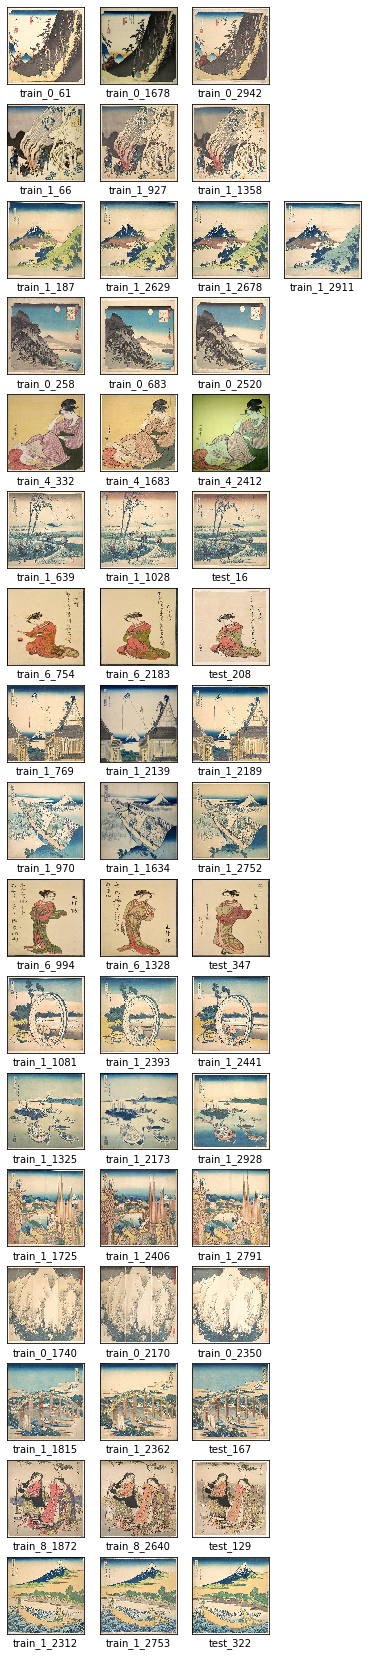

In [0]:
dups = [c for c in clusters if len(c) > 2]

print(f'{len(dups)} duplications are found')

figure = plt.figure(figsize=(8, 30))

for i, dup in enumerate(dups):
  for j, (n, x, _) in enumerate(dup[:5]):
    axis = figure.add_subplot(len(dups), 5, i * 5 + j + 1)
    axis.imshow(x)
    axis.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    axis.set_xlabel(n)

plt.show()

#モデル。
モデルはResNet18を使用。このコンペではImageNetなどの学習済みパラメータを使えないので、ネットワークの定義だけを使っています

In [0]:
model = models.resnet18(pretrained=False, num_classes=10)
model.cuda() 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#データの前処理
データ拡張はhorizontal flipのみを使用。今回の画像データは(width, height, channels)の形式になっていますが、PyTorchの入力データとするために(channels, width, height)の形式に変更しています。

In [0]:
class Dataset(dataset.Dataset):

  def __init__(self, images, labels, train=False):
    super().__init__()
    transforms = []

    if train:
      transforms.append(albumentations.HorizontalFlip(p=0.5))

    transforms.append(albumentations.ToFloat())

    self.transform = albumentations.Compose(transforms)
    self.images = images
    self.labels = labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    image = np.rollaxis(self.transform(image=self.images[idx])['image'], 2, 0)
    label = self.labels[idx]

    return image, label

train_x, valid_x, train_y, valid_y = train_test_split(
  train_images, train_labels, test_size=0.2, random_state=RANDOM_SEED)

train_loader = dataset.DataLoader(
  Dataset(train_x, train_y, train=True), batch_size=64, shuffle=True)
valid_loader = dataset.DataLoader(
  Dataset(valid_x, valid_y), batch_size=64, shuffle=False)

#学習
optimizerはadam（学習係数は0.001）を使用しています。

In [0]:
def perform(model, loader, optimizer):
  loss_total = 0
  accuracy_total = 0
  count = 0
  
  for images, labels in loader:
    images = images.cuda()
    labels = labels.cuda()

    preds = model(images)
    loss = nn.functional.cross_entropy(preds, labels)
    
    with torch.no_grad():
      accuracy = torch.mean((torch.max(preds, dim=1)[1] == labels).float())

    if optimizer is not None:
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    loss_total += float(loss.detach()) * len(images)
    accuracy_total += float(accuracy.detach()) * len(images)
    count += len(images)

  return loss_total / count, accuracy_total / count


optimizer = optim.Adam(model.parameters(), lr=0.001)
log = []

for epoch in range(10):
  model.train()

  with autograd.detect_anomaly():
    train_loss, train_accuracy = perform(model, train_loader, optimizer)

  model.eval()

  with torch.no_grad():
    valid_loss, valid_accuracy = perform(model, valid_loader, None)

  print('[{}] train(loss/accuracy)={:.2f}/{:.2f}, valid(loss/accuracy)={:.2f}/{:.2f}'.format(
    epoch + 1, train_loss, train_accuracy, valid_loss, valid_accuracy))
  
  log.append((epoch + 1, train_loss, train_accuracy, valid_loss, valid_accuracy))

[1] train(loss/accuracy)=1.54/0.46, valid(loss/accuracy)=2.05/0.36
[2] train(loss/accuracy)=1.21/0.56, valid(loss/accuracy)=1.52/0.45
[3] train(loss/accuracy)=1.10/0.61, valid(loss/accuracy)=3.37/0.41
[4] train(loss/accuracy)=1.02/0.63, valid(loss/accuracy)=1.44/0.53
[5] train(loss/accuracy)=0.92/0.67, valid(loss/accuracy)=1.73/0.51
[6] train(loss/accuracy)=0.89/0.68, valid(loss/accuracy)=3.13/0.38
[7] train(loss/accuracy)=0.81/0.71, valid(loss/accuracy)=2.07/0.45
[8] train(loss/accuracy)=0.72/0.73, valid(loss/accuracy)=1.62/0.47
[9] train(loss/accuracy)=0.69/0.76, valid(loss/accuracy)=1.20/0.61
[10] train(loss/accuracy)=0.59/0.78, valid(loss/accuracy)=1.54/0.56


#結果をグラフ化する

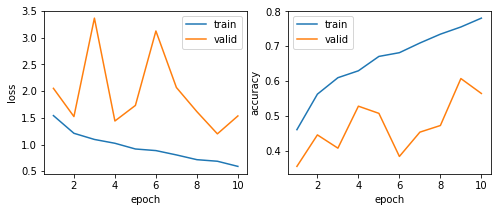

In [0]:
figure = plt.figure(figsize=(8, 3))

axis = figure.add_subplot(1, 2, 1)
axis.plot([x[0] for x in log], [x[1] for x in log], label='train')
axis.plot([x[0] for x in log], [x[3] for x in log], label='valid')
axis.set_xlabel('epoch')
axis.set_ylabel('loss')
axis.legend()

axis = figure.add_subplot(1, 2, 2)
axis.plot([x[0] for x in log], [x[2] for x in log], label='train')
axis.plot([x[0] for x in log], [x[4] for x in log], label='valid')
axis.set_xlabel('epoch')
axis.set_ylabel('accuracy')
axis.legend()

plt.show()

#推論

In [0]:
dummy_labels = np.zeros((test_images.shape[0], 1), dtype=np.int64)
test_loader = dataset.DataLoader(
  Dataset(test_images, dummy_labels), batch_size=64, shuffle=False)

test_labels = []
model.eval()

for images, _ in test_loader:
  images = images.cuda()
  
  with torch.no_grad():
    preds = model(images)
    preds = torch.max(preds, dim=1)[1]
  
  test_labels.extend(int(x) for x in preds)


print(test_labels)

[4, 1, 1, 1, 1, 4, 0, 1, 1, 9, 1, 5, 1, 9, 1, 4, 1, 1, 1, 1, 8, 1, 1, 1, 3, 3, 4, 1, 1, 1, 1, 6, 1, 1, 7, 1, 1, 1, 3, 1, 1, 4, 1, 1, 7, 1, 1, 1, 1, 0, 3, 1, 4, 7, 1, 1, 7, 5, 4, 6, 1, 1, 1, 2, 1, 1, 8, 4, 1, 0, 0, 1, 4, 1, 1, 0, 1, 1, 3, 4, 1, 2, 6, 5, 0, 2, 7, 0, 1, 1, 1, 6, 4, 5, 1, 1, 0, 3, 1, 1, 1, 5, 1, 0, 9, 7, 4, 3, 5, 7, 1, 1, 1, 3, 0, 1, 6, 6, 1, 8, 4, 1, 7, 5, 1, 4, 1, 1, 2, 5, 4, 9, 1, 1, 1, 1, 4, 0, 5, 4, 1, 1, 4, 0, 1, 1, 7, 1, 1, 1, 7, 2, 1, 7, 1, 7, 5, 0, 0, 4, 0, 1, 1, 1, 0, 6, 1, 1, 1, 4, 4, 1, 0, 0, 1, 5, 7, 4, 4, 0, 1, 6, 4, 1, 9, 4, 6, 5, 4, 1, 1, 1, 9, 8, 1, 1, 7, 0, 7, 1, 1, 2, 1, 1, 5, 6, 4, 1, 6, 1, 1, 3, 1, 1, 2, 1, 1, 4, 0, 1, 3, 1, 7, 4, 1, 7, 6, 1, 5, 0, 7, 9, 1, 4, 1, 4, 9, 1, 1, 0, 5, 1, 1, 1, 6, 1, 1, 1, 4, 1, 6, 4, 1, 4, 4, 6, 0, 8, 6, 1, 6, 7, 1, 5, 0, 1, 7, 1, 5, 7, 7, 1, 0, 5, 1, 1, 1, 1, 0, 1, 0, 5, 1, 1, 0, 1, 1, 1, 7, 2, 5, 5, 1, 1, 0, 1, 2, 0, 0, 1, 3, 1, 1, 4, 1, 4, 1, 1, 1, 1, 6, 4, 0, 1, 1, 1, 0, 1, 1, 1, 5, 7, 1, 4, 6, 6, 1, 2, 1, 2, 7, 1, 1, 

In [0]:
print(test_labels[1])

1


#提出ファイルの作成

In [0]:
with open('submission.csv', 'w') as writer:
  csv_writer = csv.writer(writer)
  csv_writer.writerow(('id', 'y'))
  csv_writer.writerows((i + 1, x) for i, x in enumerate(test_labels))

google.colab.files.download('submission.csv')
